In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, GRU
from tensorflow.keras.optimizers import Adam

2023-12-04 01:30:19.217762: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 01:30:19.826616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 01:30:19.826736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 01:30:19.940661: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 01:30:20.017748: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 01:30:20.018741: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [50]:
import string
from datetime import datetime
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def remove_stopwords(corpus):
    stop_words = set(stopwords.words('english'))
    filtered_corpus = []

    for line in corpus:
        words = line.split()
        filtered_line = ' '.join([word for word in words if word.lower() not in stop_words])
        filtered_corpus.append(filtered_line)

    return filtered_corpus

def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  corpus = remove_stopwords(corpus)

  return corpus

def get_time():
  # Get the current date and time
  current_datetime = datetime.now()

  formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H%M")

  return formatted_datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/moazzam99/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Selecting 100 hip hop songs randomly

In [144]:
import pandas as pd
all_songs = pd.read_csv("SongsData_rock.csv")
random_songs_df = all_songs.sample(n=120, random_state=42)
random_songs_df['Artist'].value_counts()

Artist
Imagine-Dragons    74
The-Beatles        29
Maroon-5           12
Coldplay            3
Onerepublic         2
Name: count, dtype: int64

# Tokeniziation and BoW

In [145]:
corpus = create_lyrics_corpus(random_songs_df,"Lyrics")
tokenizer = tokenize_corpus(corpus)
total_words = len(tokenizer.word_index)+1
print(total_words)

1492


# Generating Sequences to fit in Model

In [146]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

In [147]:
import numpy as np
max_pad_len = max([len(seq) for seq in sequences])
print(max_pad_len)
padded_sequences = np.array(pad_sequences(sequences,maxlen=max_pad_len,truncating='post'))

19


In [148]:
# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = padded_sequences[:,:-1], padded_sequences[:,-1]

# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Model Architecture and Training

In [149]:
model = Sequential()
model.add(Embedding(total_words, 128, input_length=max_pad_len-1))
#model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=10, verbose=1)

Epoch 1/10
165/165 [==============================] - 6s 17ms/step - loss: 6.6696 - accuracy: 0.0402
Epoch 2/10
165/165 [==============================] - 3s 17ms/step - loss: 5.1518 - accuracy: 0.1667
Epoch 3/10
165/165 [==============================] - 3s 17ms/step - loss: 3.5490 - accuracy: 0.3376
Epoch 4/10
165/165 [==============================] - 3s 17ms/step - loss: 2.3650 - accuracy: 0.4915
Epoch 5/10
165/165 [==============================] - 3s 17ms/step - loss: 1.6159 - accuracy: 0.6284
Epoch 6/10
165/165 [==============================] - 3s 17ms/step - loss: 1.2234 - accuracy: 0.7104
Epoch 7/10
165/165 [==============================] - 3s 17ms/step - loss: 1.0010 - accuracy: 0.7522
Epoch 8/10
165/165 [==============================] - 3s 17ms/step - loss: 0.8903 - accuracy: 0.7675
Epoch 9/10
165/165 [==============================] - 3s 18ms/step - loss: 0.8423 - accuracy: 0.7707
Epoch 10/10
165/165 [==============================] - 3s 17ms/step - loss: 0.7940 - accura

# Saving and Reloading

In [155]:
reload_model = load_model("hiphop_model_x1_2023-12-04_0106.h5")

In [25]:
history = reload_model.fit(input_sequences, one_hot_labels, epochs = 20, verbose=1)

Epoch 1/20


2023-12-04 01:46:53.461684: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 182166192 exceeds 10% of free system memory.


486/486 [==============================] - 33s 65ms/step - loss: 2.5792 - accuracy: 0.4169
Epoch 2/20
486/486 [==============================] - 32s 66ms/step - loss: 2.5370 - accuracy: 0.4255
Epoch 3/20
486/486 [==============================] - 31s 65ms/step - loss: 2.4885 - accuracy: 0.4320
Epoch 4/20
486/486 [==============================] - 30s 61ms/step - loss: 2.3803 - accuracy: 0.4454
Epoch 5/20
486/486 [==============================] - 30s 62ms/step - loss: 2.2850 - accuracy: 0.4668
Epoch 6/20
486/486 [==============================] - 34s 69ms/step - loss: 2.1961 - accuracy: 0.4802
Epoch 7/20
486/486 [==============================] - 31s 65ms/step - loss: 2.1920 - accuracy: 0.4800
Epoch 8/20
486/486 [==============================] - 31s 64ms/step - loss: 2.1066 - accuracy: 0.5005
Epoch 9/20
486/486 [==============================] - 31s 63ms/step - loss: 2.0770 - accuracy: 0.5042
Epoch 10/20
486/486 [==============================] - 30s 61ms/step - loss: 2.1134 - accurac

In [151]:
model_name = "rock_model_x1_" + get_time() + ".h5"
model.save(model_name)
print(model_name)

rock_model_x1_2023-12-04_0324.h5


/home/moazzam99/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.7902721166610718


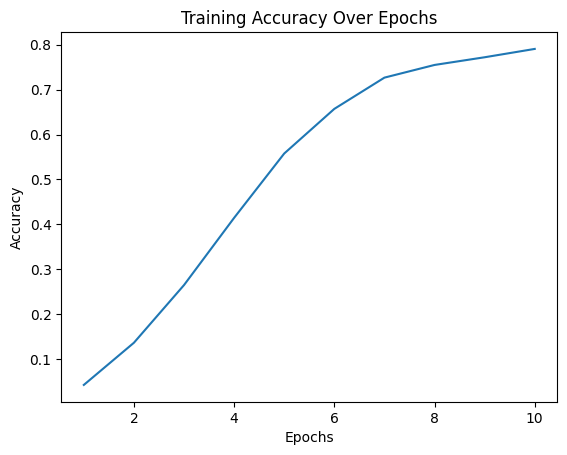

In [71]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
print(accuracy[-1])
# Plotting accuracy over epochs
plt.plot(range(1, len(accuracy) + 1), accuracy)
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [107]:
# Use this process for the full output generation
seed_text = "its beautiful"
next_words = 50
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_pad_len-1, padding='post')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 16ms/step
its beautiful pop shit life technically broke mother's court rapper like every touch ball could play play grabs well turn now gon' pop five ten i'm yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah


In [161]:
import numpy as np

def generate_text_with_temperature(seed_text, model, tokenizer, max_pad_len, next_words=50, temperature=0.9):
    generated_text = seed_text.lower()  # Convert to lowercase for case-insensitive comparison
  
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_pad_len-1, padding='post')
        
        predicted_probs = model.predict(token_list)[0]
        predicted_probs = np.log(predicted_probs) / temperature
        exp_preds = np.exp(predicted_probs)
        predicted_probs = exp_preds / np.sum(exp_preds)

        predicted_id = np.random.choice(len(predicted_probs), 1, p=predicted_probs)[0]

        output_word = tokenizer.index_word.get(predicted_id, "").lower()

        # Check if the word is not the same as the last word in the generated text
        if output_word != generated_text.split()[-1]:
            generated_text += " " + output_word

        if output_word == '<end>':
            break

    return generated_text

# Example usage:
seed_text = "here we go"
generated_text = generate_text_with_temperature(seed_text, model, tokenizer, max_pad_len, next_words=50, temperature=0.9)
print(generated_text)


1/1 [==============================] - 0s 16ms/step
here we go falling love i'm love one around i'm you i'm goes inside i'm feel go i'm space oh love


In [86]:
len(generated_text.split())

50